In [2282]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.dates as mdates

from sklearn.model_selection import train_test_split , RandomizedSearchCV, GridSearchCV,TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix , mean_squared_error, r2_score, ConfusionMatrixDisplay

from sklearn import linear_model
from sklearn.svm import SVR ,SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import SGDRegressor

In [2283]:
# Choose number of periods

# For Classifier choose 5 / Regression choose 50
number_of_periods = 50

# Choose percent test data
percent_test = 0.05

# Load dataset
dataset = pd.read_csv("commodities_12_22.csv")

# Display first five entries
dataset.head()

,Date,Crude Oil,Brent Oil,Natural Gas,Gold,Silver,Copper,Year
0,1/2/2012,NaN,NaN,NaN,NaN,28.160,NaN,2012
1,1/3/2012,102.96,112.13,2.993,1599.7,29.533,3.525,2012
2,1/4/2012,103.22,113.70,3.096,1611.9,29.063,3.429,2012
3,1/5/2012,101.81,112.74,2.980,1619.4,29.265,3.422,2012
4,1/6/2012,101.56,113.06,3.062,1616.1,28.653,3.431,2012


In [2284]:
# Check the shape of the data
dataset.shape

(3259, 8)

In [2285]:
# Describe statistics of the data
dataset.describe()

,Crude Oil,Brent Oil,Natural Gas,Gold,Silver,Copper,Year
count,2734.000000,2701.000000,2733.000000,2742.000000,3256.000000,2686.000000,3259.000000
mean,65.696774,73.710655,3.174109,1452.908888,20.324379,3.126402,2016.743173
std,22.436471,26.026078,1.058706,252.226159,5.321043,0.639881,3.026486
min,26.210000,19.330000,1.482000,1049.700000,11.772000,1.994000,2012.000000
25%,50.100000,52.370000,2.582000,1256.150000,16.319750,2.688000,2014.000000
50%,55.280000,66.550000,2.912000,1337.250000,18.071000,3.050000,2017.000000
75%,90.032500,103.460000,3.649000,1684.750000,23.897000,3.435000,2019.000000
max,122.110000,127.980000,9.322000,2054.600000,37.140000,4.912500,2022.000000


In [2286]:
# Check for null values
dataset.isnull().any()

Date           False
Crude Oil       True
Brent Oil       True
Natural Gas     True
Gold            True
Silver          True
Copper          True
Year           False
dtype: bool

In [2287]:
# Drop null values
dataset =  dataset.dropna(axis=0)
dataset.isnull().any()

Date           False
Crude Oil      False
Brent Oil      False
Natural Gas    False
Gold           False
Silver         False
Copper         False
Year           False
dtype: bool

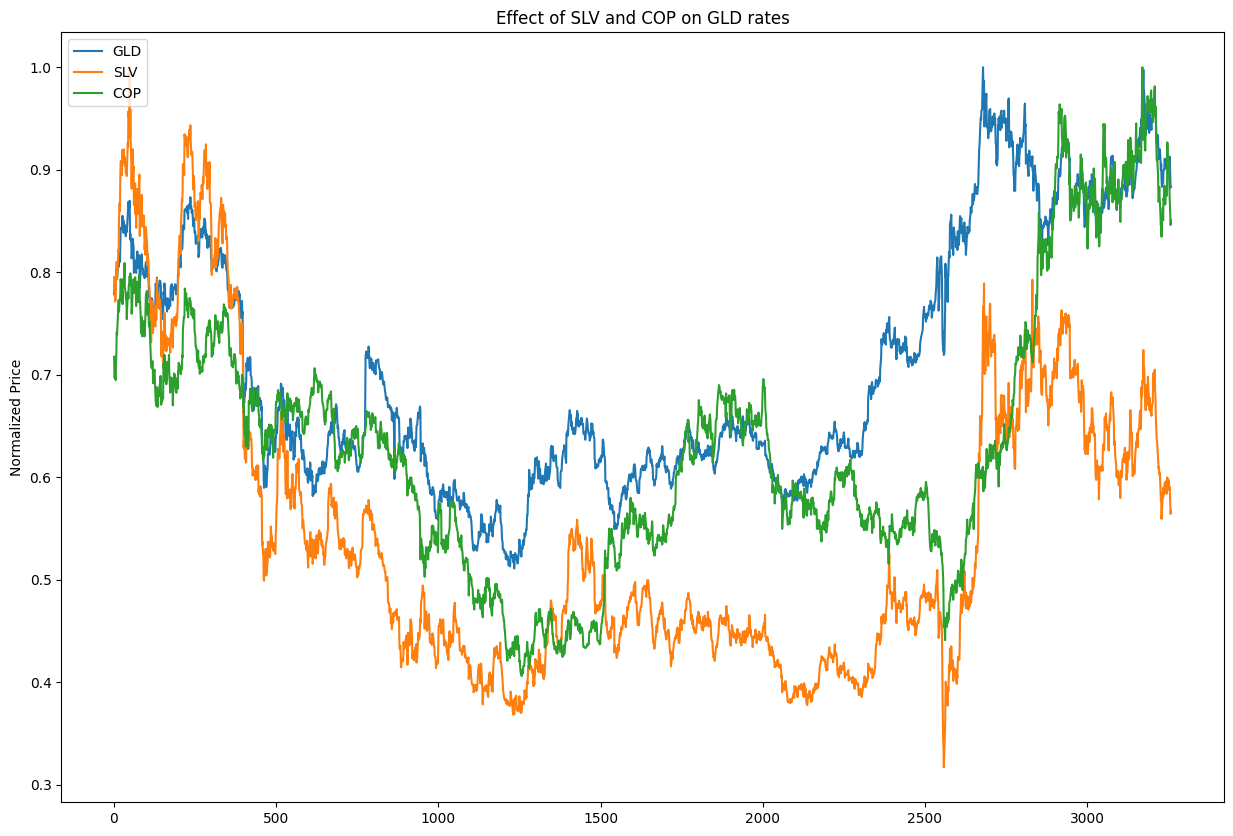

In [2288]:
GLD = dataset['Gold']
SLV = dataset['Silver']
COP  = dataset['Copper']

# Normalize GLD, SLV and COP prices for display
norm_GLD= GLD/max(GLD)
norm_SLV= SLV/max(SLV)
norm_COP= COP/max(COP)

# Plot GLD vs COP vs SLV
display_dataframe = pd.DataFrame({'GLD':norm_GLD, 'SLV':norm_SLV, 'COP':norm_COP})

display_figure = display_dataframe.plot(title='Effect of SLV and COP on GLD rates',figsize=(15,10))

display_figure.set_ylabel('Normalized Price')
display_figure.legend(loc='upper left')
plt.show()

<Axes: xlabel='Copper', ylabel='Gold'>

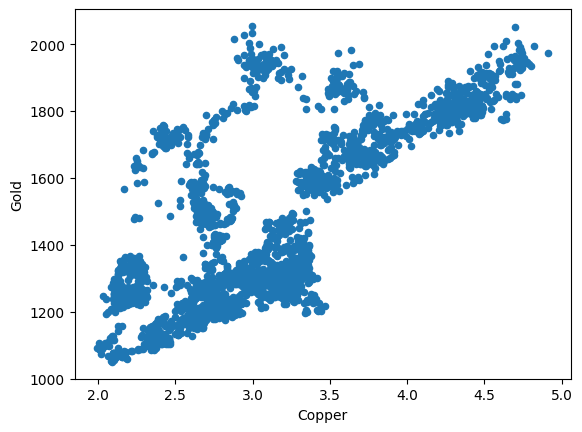

In [2289]:
# Plot GLD vs COP
dataset.plot(kind='scatter', x='Copper', y='Gold')

<Axes: xlabel='Silver', ylabel='Gold'>

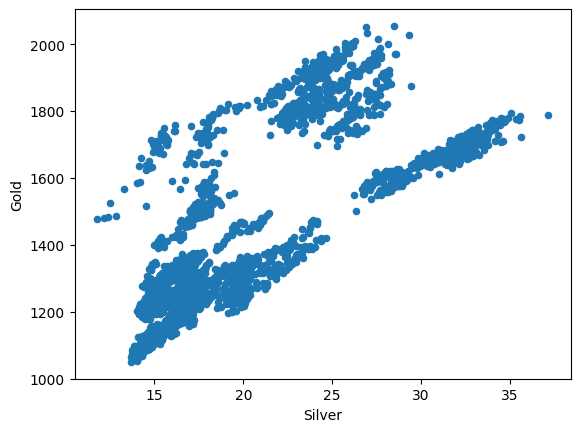

In [2290]:
# Plot GLD vs SLV
dataset.plot(kind='scatter', x='Silver', y='Gold')

<Axes: xlabel='Crude Oil', ylabel='Gold'>

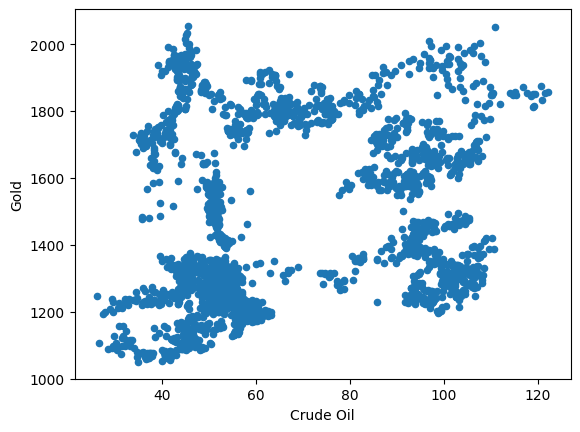

In [2291]:
# Plot GLD vs Crude Oil
dataset.plot(kind='scatter', x='Crude Oil', y='Gold')

<Axes: xlabel='Year', ylabel='Gold'>

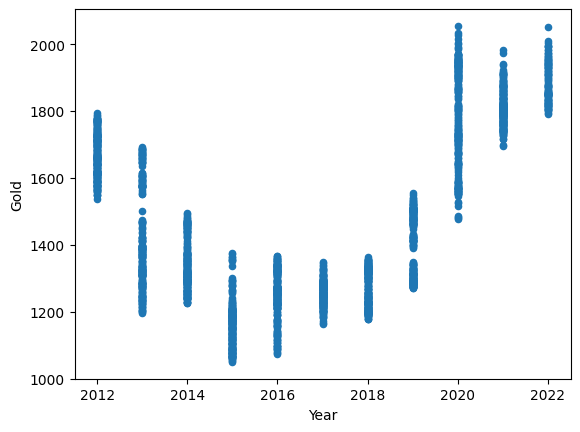

In [2292]:
# Plot GLD vs Year
dataset.plot(kind='scatter', x='Year', y='Gold')

In [2293]:
# Check correlation of features
dataset[dataset.columns[1:]].corr()['Gold'][:].sort_values(ascending=0)

Gold           1.000000
Silver         0.733645
Copper         0.713874
Year           0.424007
Crude Oil      0.233752
Brent Oil      0.218417
Natural Gas    0.197925
Name: Gold, dtype: float64

In [2294]:
# Drop features that are not sufficiently correlated
dataset = dataset.drop(columns=["Brent Oil","Natural Gas"])

In [2295]:
# Functions to calculate technical indicators
def MACD(df, nslow=26, nfast=12):
    emaslow = df.ewm(span=nslow, min_periods=nslow, adjust=True, ignore_na=False).mean()
    emafast = df.ewm(span=nfast, min_periods=nfast, adjust=True, ignore_na=False).mean()
    dif = emafast - emaslow
    MACD = dif.ewm(span=9, min_periods=9, adjust=True, ignore_na=False).mean()
    return dif, MACD

def RSI(df, periods=14):

    delta = df.diff()
    up, down = delta.copy(), delta.copy()

    up[up < 0] = 0
    down[down > 0] = 0

    rUp = up.ewm(com=periods,adjust=False).mean()
    rDown = down.ewm(com=periods, adjust=False).mean().abs()

    rsi = 100 - 100 / (1 + rUp / rDown)
    return rsi

def SMA_calculator(df, periods=15):
    SMA = df.rolling(window=periods, min_periods=periods, center=False).mean()
    return SMA

def BB(df, periods=15):
    STD = df.rolling(window=periods,min_periods=periods, center=False).std()
    SMA = SMA_calculator(df)
    upper_band = SMA + (2 * STD)
    lower_band = SMA - (2 * STD)
    return upper_band, lower_band

<Axes: title={'center': 'GLD Moving Average'}>

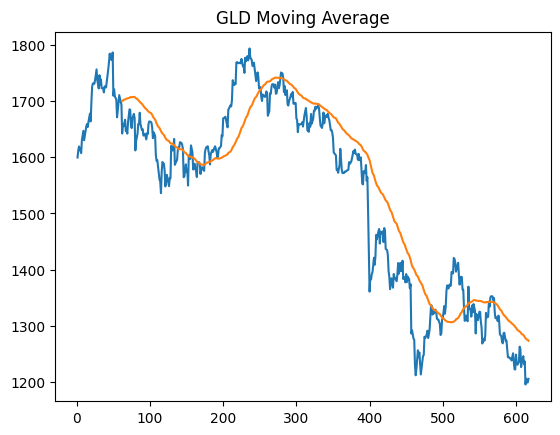

In [2296]:
# Calculate Simple Moving Average for GLD
SMA_GLD = SMA_calculator(GLD,number_of_periods)

GLD[:500].plot(title='GLD Moving Average',label='GLD')

SMA_GLD[:500].plot(label="SMA")


<Axes: >

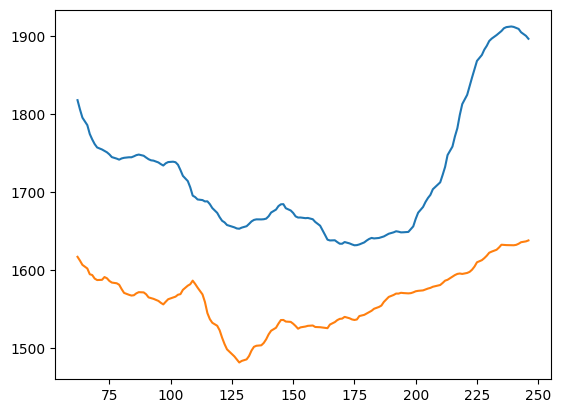

In [2297]:
# Calculate Bollinger Bands for GLD
upper_band, lower_band = BB(GLD,number_of_periods)

upper_band[:200].plot(label='upper band' )
lower_band[:200].plot(label='lower band')


<Axes: title={'center': 'DIF and MACD'}>

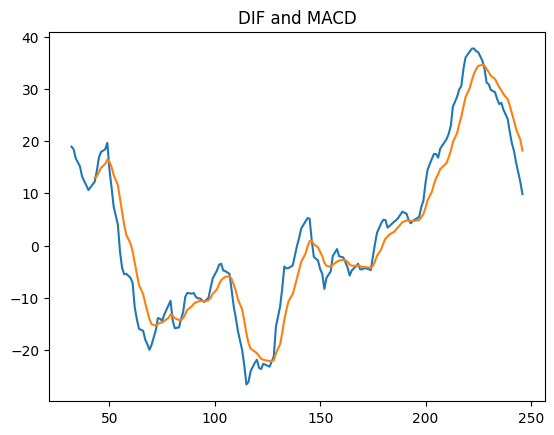

In [2298]:
# Calculate Moving Average Convergence Divergence for GLD
DIF, MACD = MACD(GLD)

DIF[:200].plot(title='DIF and MACD',label='DIF')
MACD[:200].plot(label='MACD')


<Axes: title={'center': 'RSI'}>

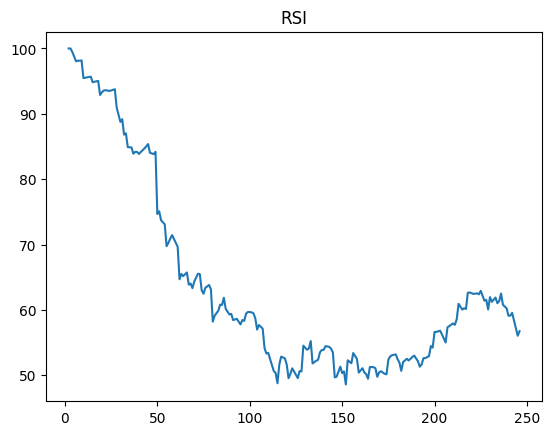

In [2299]:
# Calculate Relative Strength Index for GLD
RSI = RSI(GLD,number_of_periods)
RSI[:200].plot(title='RSI',label='RSI')


In [2300]:
# Add techincal indicators to dataset

datset_w_technical = dataset

datset_w_technical['SMA'] = SMA_GLD
datset_w_technical['Upper_band'] = upper_band
datset_w_technical['Lower_band'] = lower_band
datset_w_technical['DIF'] = DIF
datset_w_technical['MACD'] = MACD
datset_w_technical['RSI'] = RSI

In [2301]:
# Drop null entries created by calculation of technical indicators
datset_w_technical =  datset_w_technical.dropna(axis=0)
datset_w_technical.isnull().any()


Date          False
Crude Oil     False
Gold          False
Silver        False
Copper        False
Year          False
SMA           False
Upper_band    False
Lower_band    False
DIF           False
MACD          False
RSI           False
dtype: bool

In [2302]:
# Drop Date column
date=datset_w_technical["Date"]
datset_w_technical = datset_w_technical.drop(columns=["Date"])

# Scale Data
scaler = MinMaxScaler()
scaledData = scaler.fit_transform(datset_w_technical)
scaledData = pd.DataFrame(data=scaledData, index=datset_w_technical.index)

scaledData.head()

,0,1,2,3,4,5,6,7,8,9,10
62,0.826069,0.589909,0.875629,0.633202,0.0,0.716081,0.660887,0.697287,0.362260,0.416408,0.881351
63,0.822732,0.606429,0.899093,0.650334,0.0,0.717444,0.649821,0.691976,0.343252,0.394463,0.902514
64,0.843066,0.602846,0.893936,0.644167,0.0,0.718445,0.640046,0.686054,0.327331,0.373133,0.893873
66,0.853806,0.614190,0.909107,0.655131,0.0,0.719535,0.631120,0.681010,0.324037,0.355302,0.908472
67,0.827946,0.594089,0.860931,0.628405,0.0,0.720237,0.620577,0.672980,0.309520,0.337591,0.860077


In [2303]:
# Create new dataframe Gold_One_Week_Later that is the price of Gold in one week
Gold_One_Week_Later = datset_w_technical['Gold'].shift(-7)

datset_w_technical['Gold_One_Week_Later'] = Gold_One_Week_Later
datset_w_technical =  datset_w_technical.dropna(axis=0)
datset_w_technical =  datset_w_technical.drop("Gold_One_Week_Later",axis=1)
Gold_One_Week_Later =  Gold_One_Week_Later.dropna(axis=0)

cutoff =-int((percent_test*Gold_One_Week_Later.size))

validation_y = Gold_One_Week_Later[cutoff:-1]
Gold_One_Week_Later = Gold_One_Week_Later[:cutoff]

validation_X = scaledData[cutoff:-1]
scaledData = scaledData[:cutoff]


In [2304]:
# Use TimeSeries Split to split the data
ts_split= TimeSeriesSplit(n_splits=20)

for train_index, test_index in ts_split.split(scaledData):
        X_train, X_test = scaledData[:len(train_index)], scaledData[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = Gold_One_Week_Later[:len(train_index)].values.ravel(), Gold_One_Week_Later[len(train_index): (len(train_index)+len(test_index))].values.ravel()



In [2305]:
def validate_result(model, model_name):
    # Function to display RMSE and R2 score and visualize regressor accuracy
    predicted = model.predict(validation_X)
    RSME_score = np.sqrt(mean_squared_error(validation_y, predicted))
    print('RMSE: ', RSME_score)

    R2_score = r2_score(validation_y, predicted)
    print('R2 score: ', R2_score)

    plt.plot(validation_y.index, predicted,'r', label='Predict',)
    plt.plot(validation_y.index, validation_y,'b', label='Actual')
    plt.ylabel('Price')
    plt.title(model_name + ' Predict vs Actual')
    plt.legend(loc='upper right')
    plt.show()

RMSE:  37.76089766620186
R2 score:  0.6251544226205485


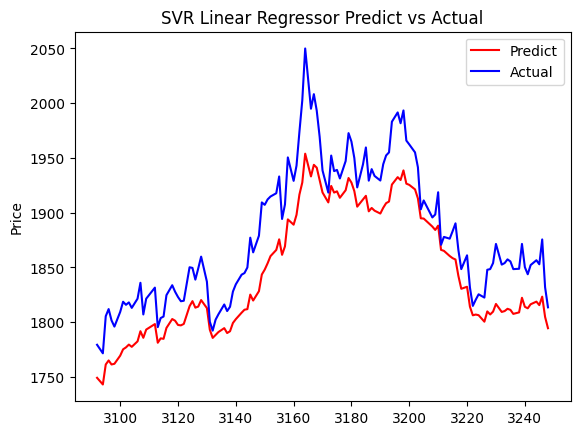

In [2306]:
# SVR with linear Kernel
SVR_linear_regressor = SVR(kernel='linear')
SVR_linear_regressor = SVR_linear_regressor.fit(X_train,y_train)

validate_result(SVR_linear_regressor,'SVR Linear Regressor')


RMSE:  4.701032047099029
R2 score:  0.9941902934732761


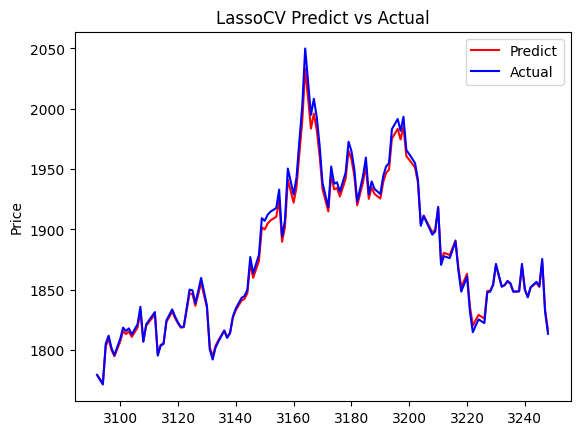

RMSE:  10.883753193808452
R2 score:  0.9688595315746826


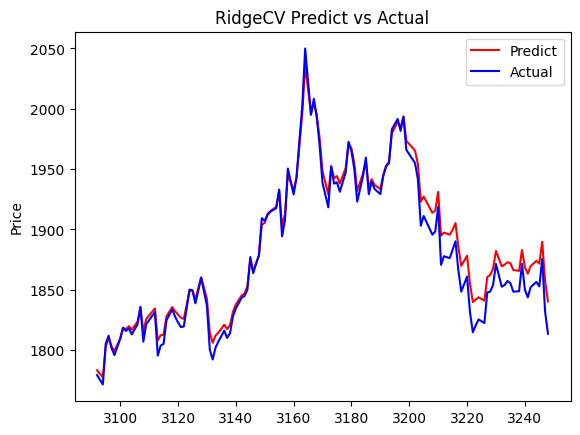

In [2307]:
# Lasso and Ridge Regressors
lasso_regressor = LassoCV(cv =10, n_alphas=1000, random_state=0)
ridge_regressor = RidgeCV(cv=5)

lasso_regressor = lasso_regressor.fit(X_train,y_train)
validate_result(lasso_regressor,'LassoCV')

ridge_regressor = ridge_regressor.fit(X_train,y_train)
validate_result(ridge_regressor,'RidgeCV')

RMSE:  10.297743244023208
R2 score:  0.9721226241885953


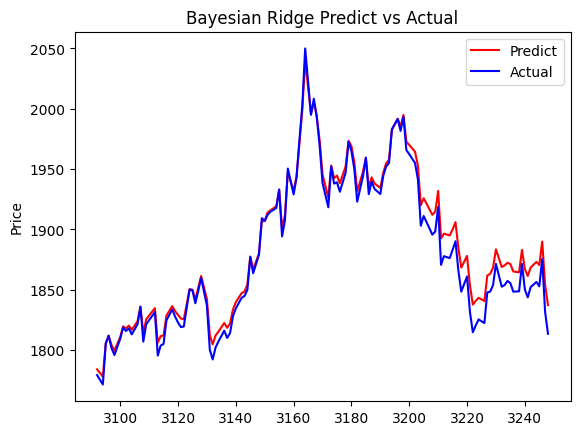

In [2308]:
# Bayesian Ridge regressor
bayesian_regressor = BayesianRidge()
bayesian_regressor = bayesian_regressor.fit(X_train,y_train)
validate_result(bayesian_regressor,'Bayesian Ridge')

RMSE:  16.161294999920393
R2 score:  0.9313374249518732


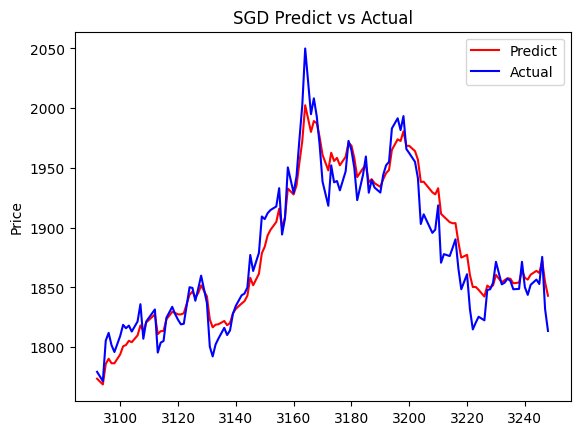

In [2309]:
# Bayesian SGD regressor
sgd_regressor =SGDRegressor(tol=0.0001,loss='squared_epsilon_insensitive',penalty='elasticnet',alpha=0.01)

sgd_regressor = sgd_regressor.fit(X_train,y_train)
validate_result(sgd_regressor,'SGD')

In [2310]:
# Process dataset again for Classifers
Gold_One_Week_Later = (dataset['Gold'].shift(-7)-dataset['Gold'])>0

Gold_One_Week_Later = Gold_One_Week_Later.astype(int)


datset_w_technical = dataset

datset_w_technical['SMA'] = SMA_GLD
datset_w_technical['Upper_band'] = upper_band
datset_w_technical['Lower_band'] = lower_band
datset_w_technical['DIF'] = DIF
datset_w_technical['MACD'] = MACD
datset_w_technical['RSI'] = RSI

datset_w_technical =  datset_w_technical.dropna(axis=0)
datset_w_technical.isnull().any()

date=datset_w_technical["Date"]
datset_w_technical = datset_w_technical.drop(columns=["Date"])

scaler = MinMaxScaler()
scaledData = scaler.fit_transform(datset_w_technical)
scaledData = pd.DataFrame(data=scaledData, index=datset_w_technical.index)

datset_w_technical['Gold_One_Week_Later'] = Gold_One_Week_Later
datset_w_technical =  datset_w_technical.dropna(axis=0)
datset_w_technical =  datset_w_technical.drop("Gold_One_Week_Later",axis=1)
Gold_One_Week_Later =  Gold_One_Week_Later.dropna(axis=0)

cutoff =-int((percent_test*Gold_One_Week_Later.size))

validation_y = Gold_One_Week_Later[cutoff:-1]
Gold_One_Week_Later = Gold_One_Week_Later[:cutoff]

validation_X = scaledData[cutoff:-1]
scaledData = scaledData[:cutoff]

display(Gold_One_Week_Later.head(10))

1     1
2     1
3     1
4     1
6     1
7     1
8     1
9     1
10    1
13    1
Name: Gold, dtype: int64

In [2311]:
# Split Data using TimeSeriesSplit
ts_split= TimeSeriesSplit(n_splits=10)
for train_index, test_index in ts_split.split(scaledData):
        X_train, X_test = scaledData[:len(train_index)], scaledData[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = Gold_One_Week_Later[:len(train_index)].values.ravel(), Gold_One_Week_Later[len(train_index): (len(train_index)+len(test_index))].values.ravel()


Accuracy: 0.49333333333333335
Confusion Matrix:
[[33 76]
 [38 78]]


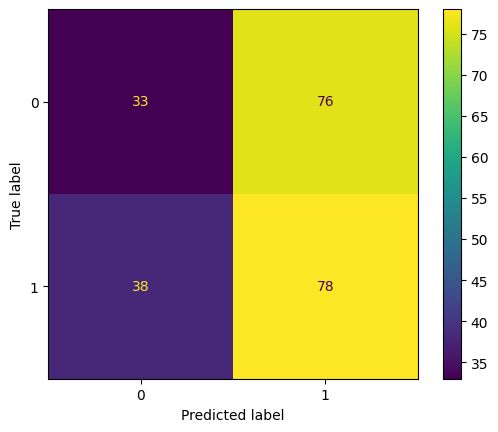

In [2312]:
# SVM classifier with poly kernel
SVM = SVC(kernel='poly')

linear_svr_clf_feat = SVM.fit(X_train,y_train)

y_pred = SVM.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=linear_svr_clf_feat.classes_)

disp.plot()
plt.show()


{'n_estimators': 200, 'max_depth': 3}
Accuracy: 0.4711111111111111
Confusion Matrix:
[[ 93  16]
 [103  13]]


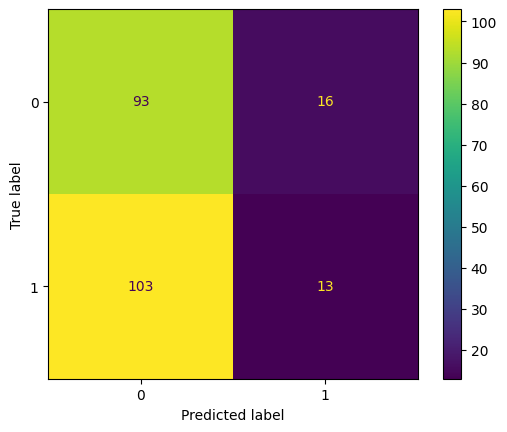

In [2313]:
param_dist = {'n_estimators': [100,125,150,175,200,400],
              'max_depth': [3,4,5,6,7,8]}

# Create a random forest classifier
SVM = RandomForestClassifier()
linear_svr_clf_feat = SVM.fit(X_train,y_train)
# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(linear_svr_clf_feat,
                                 param_distributions = param_dist,
                                 n_iter=5,
                                 cv=5)
rand_search.fit(X_train, y_train)
# Fit the random search object to the data

print(rand_search.best_params_)

y_pred = SVM.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=linear_svr_clf_feat.classes_)

disp.plot()
plt.show()


Accuracy: 0.6133333333333333
Confusion Matrix:
[[82 27]
 [60 56]]


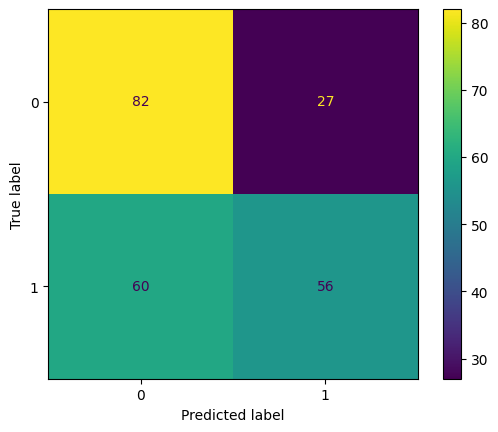

In [2314]:
# Logistic Regression Classifier
logistic_regression_classifier = LogisticRegression(solver='liblinear', penalty='l1',C=5,max_iter=20000)
logistic_regression_classifier = logistic_regression_classifier.fit(X_train,y_train)

y_pred = logistic_regression_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logistic_regression_classifier.classes_)

disp.plot()
plt.show()

Accuracy: 0.5155555555555555
Confusion Matrix:
[[  0 109]
 [  0 116]]


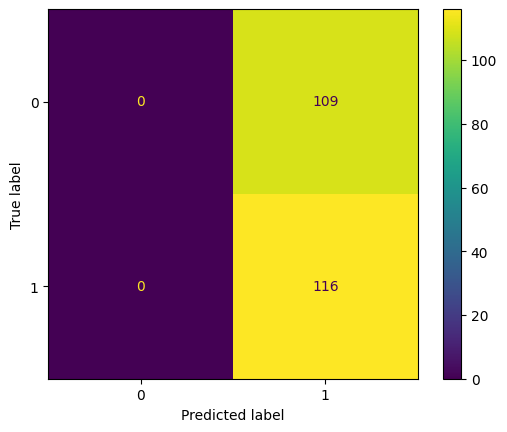

In [2315]:
# Gaussian Naive Bayes Classifier
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

y_pred = gnb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=linear_svr_clf_feat.classes_)

disp.plot()
plt.show()


Accuracy: 0.47555555555555556
Confusion Matrix:
[[ 96  13]
 [105  11]]


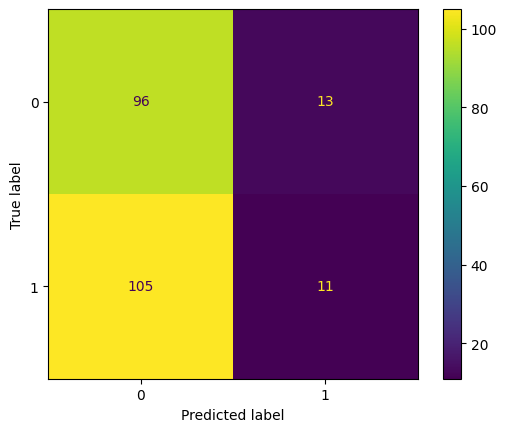

In [2316]:
# K-Neighbors classifier
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=15)
y_pred= neigh.fit(X_train, y_train).predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=linear_svr_clf_feat.classes_)

disp.plot()
plt.show()